# Bike Sharing Problem- Shubham Kumar


## About Dataset

We are provided hourly rental data spanning two years. The training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. We must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

### Data Fields


datetime - hourly date + timestamp  

season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 

holiday - whether the day is considered a holiday

workingday - whether the day is neither a weekend nor holiday

weather -   1: Clear, Few clouds, Partly cloudy, Partly cloudy
            2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
            3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
            4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 

temp - temperature in Celsius

atemp - "feels like" temperature in Celsius

humidity - relative humidity

windspeed - wind speed

casual - number of non-registered user rentals initiated

registered - number of registered user rentals initiated

count - number of total rentals

In [14]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sn
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [15]:
def rmsle(y, y_):
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

In [16]:
dtrain=pd.read_csv('train.csv')
dtest=pd.read_csv('test.csv')

### Data Overview

In [17]:
dtrain.shape

(10886, 12)

In [18]:
dtrain.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


In [19]:
dtrain.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

## Splitting of datetime into new columns

In [20]:
d=dtrain.append(dtest)
d.reset_index(inplace=True)
d.drop('index',inplace=True,axis=1)
d["date"] = d.datetime.apply(lambda x : x.split()[0])
d["hour"] = d.datetime.apply(lambda x : x.split()[1].split(":")[0]).astype("int")
d["year"] = d.datetime.apply(lambda x : x.split()[0].split("-")[0])
d["weekday"] = d.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").weekday())
d["month"] = d.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").month)


## Random Forest Regressor to fill in the values for 0 wind speed. 

In [21]:
dwind0=d[d['windspeed']==0]
dwindnot0=d[d['windspeed']!=0]
wind_model=RandomForestRegressor()
field=['season','weather','humidity','month','temp','year']
wind_model.fit(dwindnot0[field],dwindnot0['windspeed'])
values_wind=wind_model.predict(X=dwind0[field])
dwind0['windspeed']=values_wind
data=dwindnot0.append(dwind0)
data.reset_index(inplace=True)
data.drop('index',inplace=True,axis=1)

## Coercing into categorical data

In [22]:
cat_var_list=["season","holiday","workingday","weather","weekday","month","year","hour"]
for i in cat_var_list:
    data[i]=data[i].astype('category')

In [23]:
dtrain=data[pd.notnull(data['count'])].sort_values(by=['datetime'])
dtest=data[~pd.notnull(data['count'])].sort_values(by=['datetime'])


# Data Visualizing 

[Text(0,0.5,u'Count'),
 Text(0.5,0,u'Working Day'),
 Text(0.5,1,u'Box Plot On Count Over Working Day')]

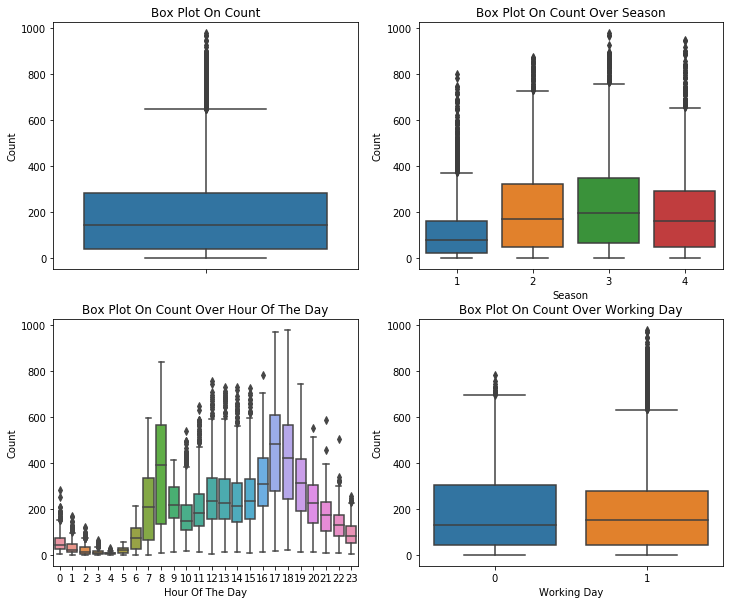

In [24]:
%matplotlib inline
fig,axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sn.boxplot(data=dtrain,y="count",orient="v",ax=axes[0][0])
sn.boxplot(data=dtrain,y="count",x="season",orient="v",ax=axes[0][1])
sn.boxplot(data=dtrain,y="count",x="hour",orient="v",ax=axes[1][0])
sn.boxplot(data=dtrain,y="count",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Over Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Over Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Over Working Day")



From the above box plots distribution of count overseasons, hours of the day and working or non working day are shown.

i) Box Plot on count shows the median of the total count per day lie around 150-200.

ii) The median for the count of rented bikes has a drop in spring season.

iii) From the box plot on count over the Hours of the day, it can be seen cearly that the peak of count of rented bikes lies between 7-9 am and 5-7 pm. this could account for the school going chlidren and office going adults renting the bikes to go to their destination. 

iv) The median for both working and non working days are approximately equal but most of the outliers are contibuted from working days only. 

# Correlation Matrix Visualisation


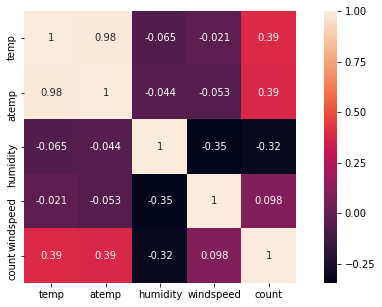

In [25]:
%matplotlib inline
corrMatt = dtrain[["temp","atemp","humidity","windspeed","count"]].corr()
fig,ax= plt.subplots()
fig.set_size_inches(10,5)
sn.heatmap(corrMatt,vmax=1,square=True,annot=True)



# Distribution Plot for Count

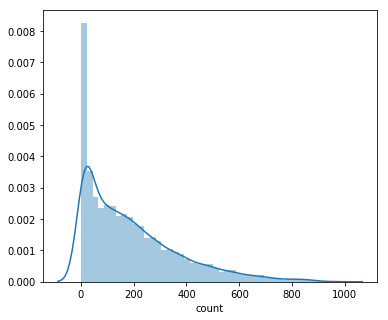

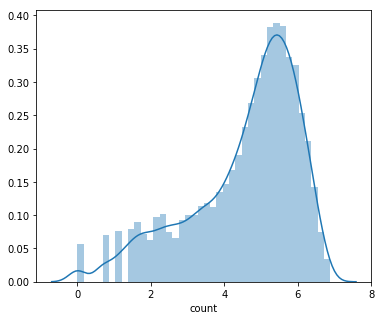

In [26]:
%matplotlib inline
fig,axes = plt.subplots()
fig.set_size_inches(6, 5)
sn.distplot(dtrain["count"])
fig,axes = plt.subplots()
fig.set_size_inches(6,5)
sn.distplot(np.log(dtrain["count"]))


From the above plots we can see that the count field does not follow the Normal Distribtion curve, it is being skewed towards the right. Many ML Algorithms require the dependent variable to follow Normal Distribution to work properly. Here the latter plot is for the count variable after being transformed by Logarithmic Transformation. It can be considered following Normal Distribution with some error terms. 

In [27]:
drop_list=['casual','registered','datetime','count','date']

y_val=dtrain['count']
y_log=np.log(y_val)
date_time=dtest['datetime']
dtrain=dtrain.drop(drop_list,axis=1)
dtest=dtest.drop(drop_list,axis=1)

In [28]:
Xtrain,Xtest,Ytrain,Ytest=train_test_split(dtrain,y_log,test_size=0.2,random_state=7)

## Linear Regression Model 

In [29]:
lin_model=LinearRegression()
lin_model.fit(X=Xtrain,y=Ytrain)
predict_linear=lin_model.predict(X=Xtest) 
print("RMSLE for Linear Regressor: ",rmsle(np.exp(Ytest),np.exp(predict_linear)))


('RMSLE for Linear Regressor: ', 0.99421087998118862)


## Random Forest 

In [30]:
#randomforest 
rf_model=RandomForestRegressor(n_estimators=500,random_state=7)
rf_model.fit(X=Xtrain,y=Ytrain)
predict_rf=rf_model.predict(X=Xtest)
print("RMSLE for Random Forest Regressor: ",rmsle(np.exp(Ytest),np.exp(predict_rf)))

('RMSLE for Random Forest Regressor: ', 0.2905586459230487)


## Gradient Boost



In [31]:
gb_model = GradientBoostingRegressor(n_estimators=500,random_state=7)
gb_model.fit(Xtrain,Ytrain)
predict_gb = gb_model.predict(X=Xtest)
print("RMSLE for Gradient Boosting Regressor: ",rmsle(np.exp(Ytest),np.exp(predict_gb)))

('RMSLE for Gradient Boosting Regressor: ', 0.28470449418481591)


In [32]:
# =============================================================================
# pred_test=gb_model.predict(X=dtest)
# output=pd.DataFrame({
#         'datetime': date_time,
#         'count': [max(0,x)for x in np.exp(pred_test)]
#         })
# print output.head(3)
# output.to_csv('lin_model.csv')
# 
# =============================================================================


## Comparision when trained without applying the Logarithmic Transformation on Count


In [33]:
Xtrain,Xtest,Ytrain,Ytest=train_test_split(dtrain,y_val,test_size=0.2,random_state=7)

### Linear Regression

In [34]:
lin_model2=LinearRegression()
lin_model2.fit(Xtrain,Ytrain)
predict_linear2=lin_model2.predict(Xtest)
print("RMSLE for Linear Regressor without log: ",rmsle(Ytest,predict_linear2))

('RMSLE for Linear Regressor without log: ', 1.2403112151728133)


/home/ojas/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


### Random Forest Regression

In [35]:
rf_model2=RandomForestRegressor(n_estimators=500,random_state=7)
rf_model2.fit(Xtrain,Ytrain)
predict_rf2=rf_model2.predict(X=Xtest)
print("RMSLE for Random Forest Regressor without log: ",rmsle(Ytest,predict_rf2))

('RMSLE for Random Forest Regressor without log: ', 0.32591000625648692)


We can clearly see that same algorithms give better results when the target variable is following Normal Distribution.